In [1]:
import feltorutilities as fp
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [2]:
physicals=list()
for res in np.sort([3e-4,1e-4,3e-5,1e-5,3e-6,1e-6]):
    params = {"name" : "Compass",
    "beta" : 1e-4, "resistivity": res, #change both to change n_0
    "tau" : 1, "m_i" : fp.deuteron_mass, "R_0" : 545, "R": 0.545,
    "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32}
    physical = {"m_i" : fp.deuteron_mass,  "R": 0.545, "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32 }
    fp.numerical2physical( params, physical)
    physicals.append(physical)
physicals[0]

{'m_i': 3.3435837724e-27,
 'R': 0.545,
 'a': 0.175,
 'q': 2,
 'scaleR': 1.45,
 'Nz': 32,
 'T_e': 77.76088568677834,
 'n_0': 1.0365292381027862,
 'B_0': 1.2738887631949316,
 'T_i': 77.76088568677834}

In [3]:
# 3e-4, 1e-4, 3e-5, 1e-5, 3e-6, 1e-6
omega_s1 = [2e-4, 1e-4, 5e-5, 3.5e-5, 3e-5, 2.5e-5]
omega_s0 = [1.6e-4, 7e-5, 5e-5, 3.5e-5, 3e-5, 2.5e-5]
omega_s1.reverse()
omega_s0.reverse()
omega_s0

[2.5e-05, 3e-05, 3.5e-05, 5e-05, 7e-05, 0.00016]

In [4]:
data=list()
columns=[*physicals[0].keys(), *fp.quantities() ]
for physical in physicals:
    data.append( fp.parameters2quantities( physical, columns))
df = pd.DataFrame( data, columns=columns)
df['omega_s1'] = omega_s1
df['omega_s0'] = omega_s0
df['omega_s1s'] = df['omega_s1']/df['omega_0_inv']/1000
df['omega_s0s'] = df['omega_s0']/df['omega_0_inv']/1000
df['omega_s0s']

0   1.53e+00
1   1.39e+00
2   1.20e+00
3   1.30e+00
4   1.35e+00
5   2.35e+00
Name: omega_s0s, dtype: float64

In [5]:
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x
def errorToString(x):
    return '%.2e' % x

In [6]:

for s in ["n_0", "R", "m_i", "rho_s"]:
    print( s, "\t\t", fp.parameters2quantity( physical, s))
show = ["resistivity", "B_0", "T_e", 'omega_s0s', 'omega_s1s']
df_str = df[show]
for header in ["resistivity"] :  
    df_str[header] = df_str[header].apply( errorToString)
for header in ["B_0", "T_e", "omega_s0s", "omega_s1s"] :  
    df_str[header] = df_str[header].apply( orderToString)
# df_str.loc[0,'omega_s0s'] = '('+df_str['omega_s0s'][0]+', '+df_str['omega_s1s'][0]+')'
# df_str.loc[1,'omega_s0s'] = '('+df_str['omega_s0s'][1]+', '+df_str['omega_s1s'][1]+')'
# df_str = df_str.drop('omega_s1s',axis=1)
df_str.columns = ["$\eta$","$B_0/$T", "$T_e/$eV", "$\omega_s^0 / $kHz", "$\omega_s^1 / $kHz"]

df_str.set_index("$\eta$", inplace=True)

filename = "parameters.tex"
with open(filename, 'wb') as f:
    f.write(bytes(df_str.style.to_latex(
        column_format='rrrrc', hrules=True),'UTF-8'))
    

df_str

n_0 		 1.0365292382629698
R 		 0.545
m_i 		 3.3435837724e-27
rho_s 		 0.0010000000000355684


/tmp/ipykernel_14366/3810470510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_str[header] = df_str[header].apply( errorToString)
/tmp/ipykernel_14366/3810470510.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_str[header] = df_str[header].apply( orderToString)


,$B_0/$T,$T_e/$eV,$\omega_s^0 / $kHz,$\omega_s^1 / $kHz
$\eta$,,,,
1.00e-06,1.27,77.76,1.53,1.53
3.00e-06,0.97,44.90,1.39,1.39
1.00e-05,0.72,24.59,1.20,1.20
3.00e-05,0.54,14.20,1.30,1.30
1.00e-04,0.40,7.78,1.35,1.93
3.00e-04,0.31,4.49,2.35,2.93


In [7]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time
import pyfeltor.dg as dg

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [8]:
data = simplesim.Manager( directory="./resistivity-new-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="./resistivity-new-diag", filetype="nc")
outfiles = simplesim.Manager( directory = "./resistivity-new-data", filetype="out" )

In [9]:
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x
def errorToString(x):
    return '%.2e' % x
def intToString(x):
    return '%02d' % x

In [10]:
filelist = diag.table()
filelist = sorted( filelist , key=lambda d: (d['physical']['tau'], d['physical']['resistivity']))
for pp in filelist:    
    print( diag.outfile( pp), " split into ", diag.count( pp), " file(s)",
          "tau", pp["physical"]["tau"], "res", pp["physical"]["resistivity"])

to_plot = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
}
for pp in filelist :
    da = Dataset(diag.outfile(pp,diag.count(pp)-1))
    time_ = np.asarray(da['time'][:])
    deltat = np.diff(np.append(time_, 2*time_[-1] -time_[-2]))
    tau = pp["physical"]["tau"]
    res = pp["physical"]["resistivity"]
    to_plot["res"][tau].append(res)
    to_plot["times"][tau][res] = time_
    to_plot["params"][tau][res] = pp 
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
# Create simulation times table
datalist=list()
columns=[r"$\eta$",'a', 'b', 'c', 'd']

for res in to_plot['res'][0]:
    line = list()
    line.append(res)
    for tau in to_plot['tau'] :
        timescale = fp.omega_0_inv(**to_plot["params"][tau][res]['physical'])*1e3 # in ms
        line.append( to_plot['times'][tau][res][-1])
        line.append( to_plot['times'][tau][res][-1]*timescale)
        
        #print( tau, res, to_plot['times'][tau][res][-1], to_plot['times'][tau][res][-1]*timescale)
    datalist.append(line)
df = pd.DataFrame( datalist, columns=columns) 
df.sort_values( by = r'$\eta$', inplace=True)
df_str = df
for header in ["$\eta$"] :  
    df_str[header] = df_str[header].apply( errorToString)
for header in ['a', 'c'] :  
    df_str[header] = df_str[header].apply( intToString)
for header in ['b', 'd'] :  
    df_str[header] = df_str[header].apply( orderToString)
df_str.set_index("$\eta$", inplace=True)

columns = [(r"$T_i=0$", r"$t_\mathrm{end}/\Omega_{i0}^{-1}$"), (r"$T_i=0$",r"$t_\mathrm{end}/$ms"),
                (r"$T_i=T_e$", r"$t_\mathrm{end}/\Omega_{i0}^{-1}$"), (r"$T_i=T_e$",r"$t_\mathrm{end}/$ms" )]
df.columns=pd.MultiIndex.from_tuples(columns)

filename = "endtimes.tex"
with open(filename, 'wb') as f:
    f.write(bytes(df_str.style.to_latex(
        column_format='rrrrr', hrules=True),'UTF-8'))
    

df_str


./resistivity-new-diag/e8025de1880299210c2ceeb01db51e00ac9d8087.nc  split into  7  file(s) tau 0 res 1e-06
./resistivity-new-diag/5a1869d7ed70394c1bd05e9c610623517269179d.nc  split into  7  file(s) tau 0 res 3e-06
./resistivity-new-diag/1f1ab687243422011a4b80ed9684a5e0cd49477a.nc  split into  7  file(s) tau 0 res 1e-05
./resistivity-new-diag/d7fc0440a0efb4ff396e056b90b99ec29c1b194e.nc  split into  10  file(s) tau 0 res 3e-05
./resistivity-new-diag/7f852ba3d56765383228e963268ee9593583c96e.nc  split into  9  file(s) tau 0 res 0.0001
./resistivity-new-diag/fcc094a5a840a5bc898a012a88a3e8856e94d95c.nc  split into  10  file(s) tau 0 res 0.0003
./resistivity-new-diag/a658b772ad9f39a9a2e6a026c0c6db8cd0177299.nc  split into  7  file(s) tau 1 res 1e-06
./resistivity-new-diag/2fee6c9244f095a4c348e5c9bb8a12a57e10786e.nc  split into  7  file(s) tau 1 res 3e-06
./resistivity-new-diag/bb9743ce9505b22bf7474671f3ecef8a340e83bf.nc  split into  7  file(s) tau 1 res 1e-05
./resistivity-new-diag/a9c2c59b90

/home/matthias/Projekte/utilities-feltor/feltorutilities.py:137: RuntimeWarning: invalid value encountered in scalar power
  cte.epsilon_0**2 * n_0*1e19 / B_0 / (T_e*cte.eV)**(3/2)


$T_i=0$                      \
         $t_\mathrm{end}/\Omega_{i0}^{-1}$ $t_\mathrm{end}/$ms   
$\eta$                                                           
1.00e-06                            110400                1.81   
3.00e-06                            110200                2.38   
1.00e-05                             97500                2.84   
3.00e-05                            100000                3.83   
1.00e-04                             89165                4.62   
3.00e-04                            100000                6.82   

                                 $T_i=T_e$                      
         $t_\mathrm{end}/\Omega_{i0}^{-1}$ $t_\mathrm{end}/$ms  
$\eta$                                                          
1.00e-06                            111800                1.83  
3.00e-06                            111200                2.40  
1.00e-05                             88800                2.59  
3.00e-05                            100000                3.83  
1.00e-04                            100000                5.18  
3.00e-04                             99800                6.80

./resistivity-new-data/e8025de1880299210c2ceeb01db51e00ac9d8087.out 0 1e-06
5.3±0.7
0.046


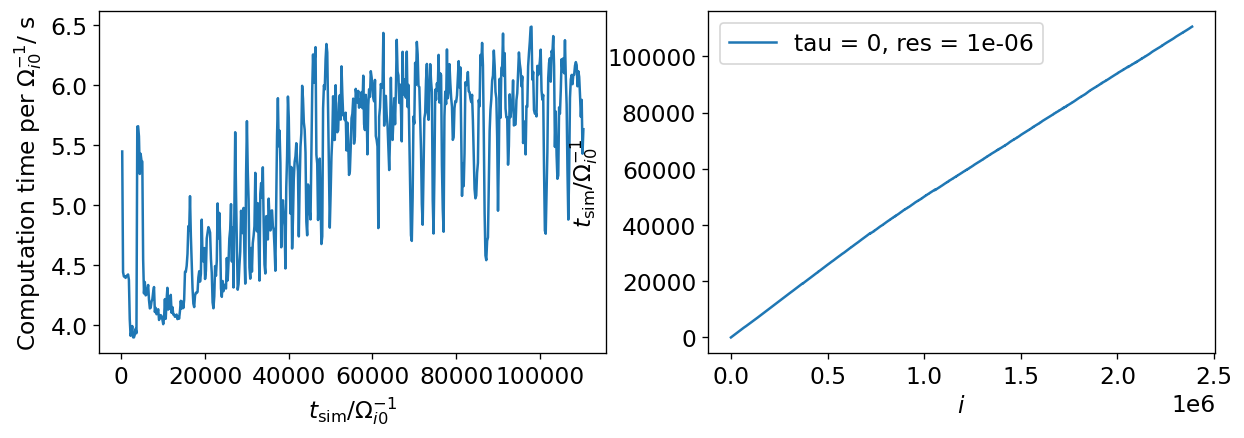

./resistivity-new-data/5a1869d7ed70394c1bd05e9c610623517269179d.out 0 3e-06
5.3±0.8
0.046


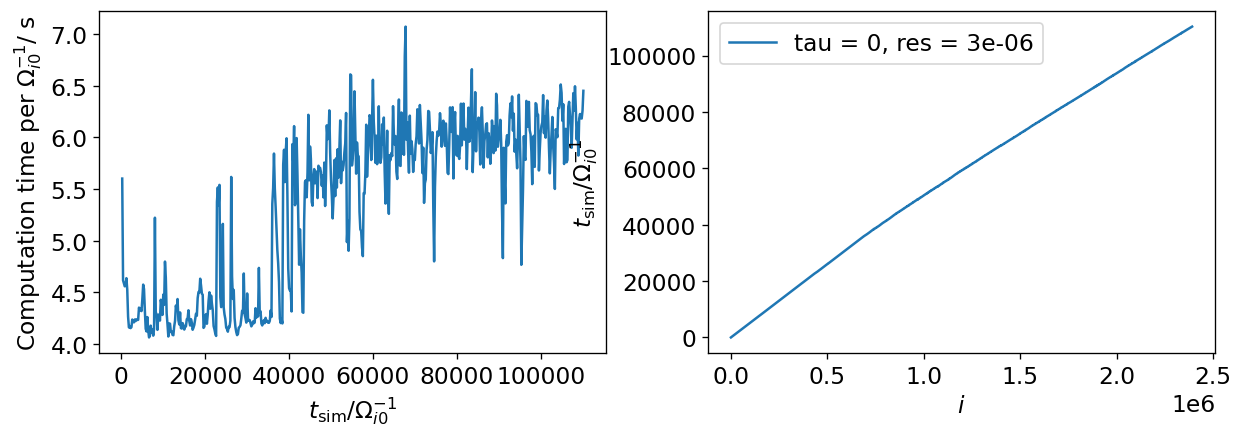

./resistivity-new-data/1f1ab687243422011a4b80ed9684a5e0cd49477a.out 0 1e-05
5.6±1.0
0.045


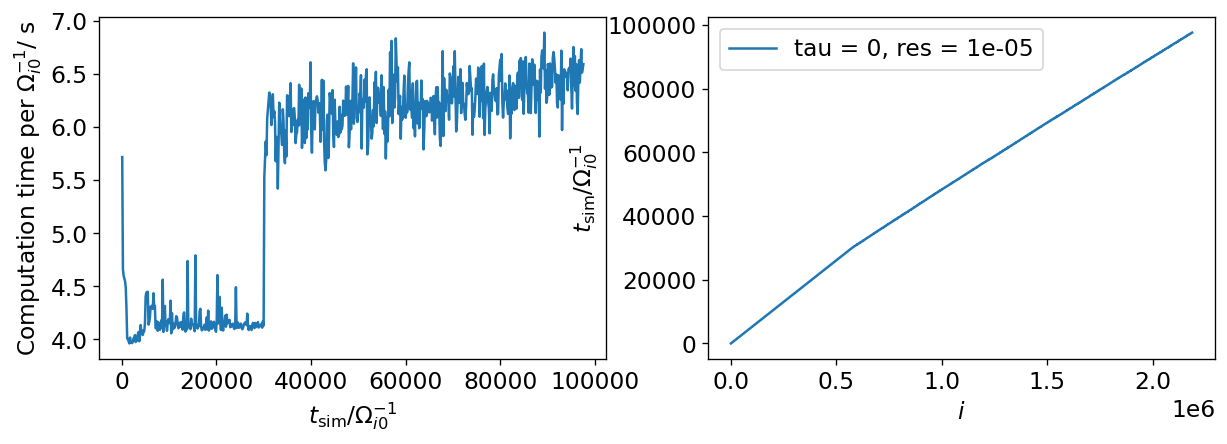

./resistivity-new-data/d7fc0440a0efb4ff396e056b90b99ec29c1b194e.out 0 3e-05
7.2±0.2
0.030


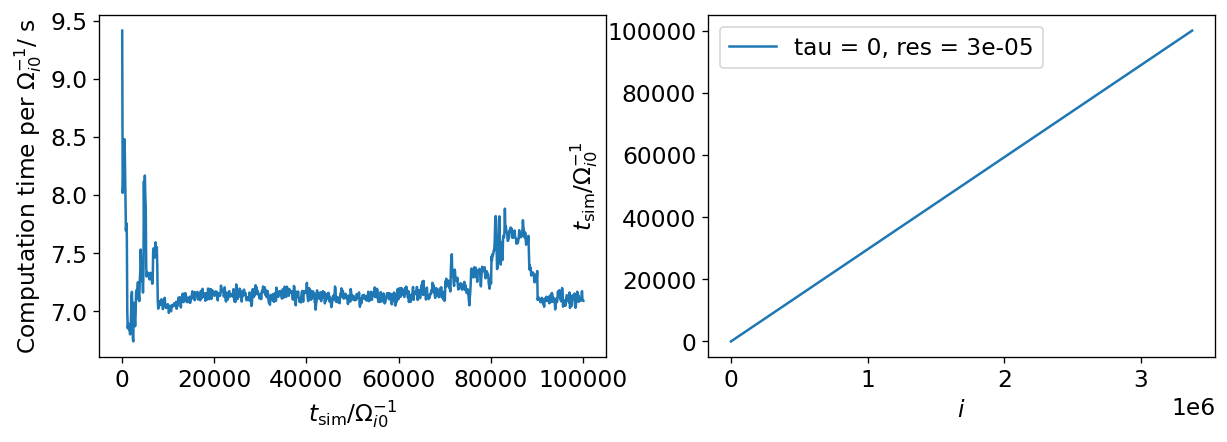

./resistivity-new-data/7f852ba3d56765383228e963268ee9593583c96e.out 0 0.0001
4.6±0.6
0.051


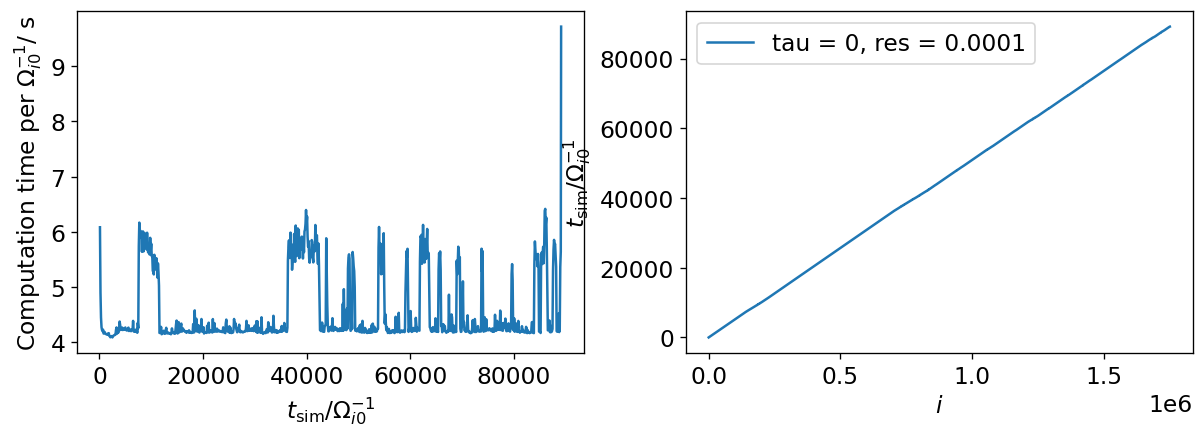

./resistivity-new-data/fcc094a5a840a5bc898a012a88a3e8856e94d95c.out 0 0.0003
6.1±0.4
0.043


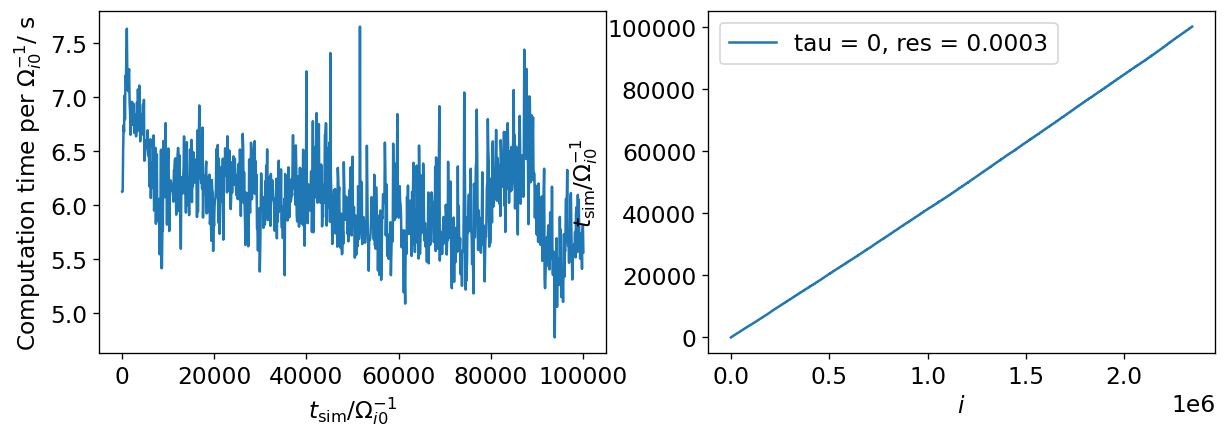

./resistivity-new-data/a658b772ad9f39a9a2e6a026c0c6db8cd0177299.out 1 1e-06
5.3±0.2
0.047


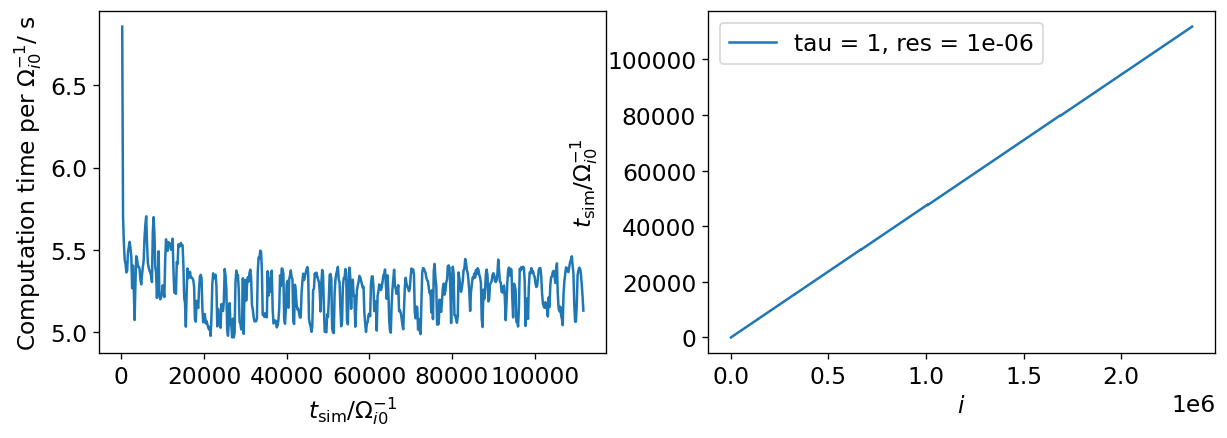

./resistivity-new-data/2fee6c9244f095a4c348e5c9bb8a12a57e10786e.out 1 3e-06
5.3±0.2
0.047


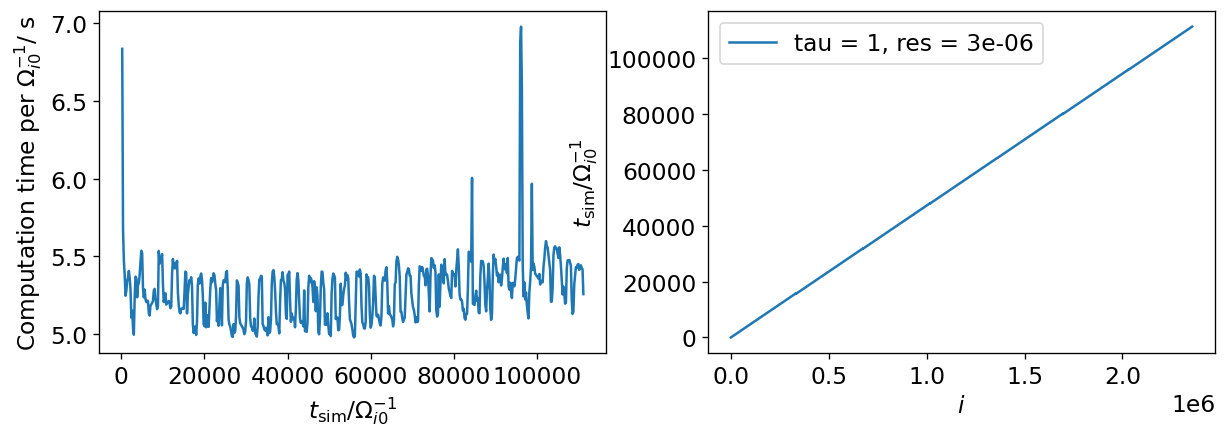

./resistivity-new-data/bb9743ce9505b22bf7474671f3ecef8a340e83bf.out 1 1e-05
6.6±0.3
0.037


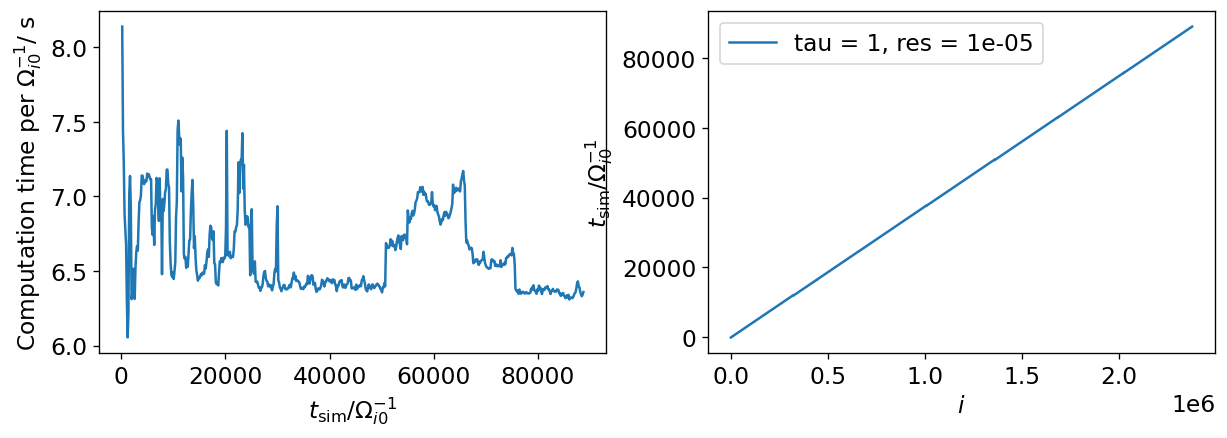

./resistivity-new-data/a9c2c59b90af00fe9a0ecc143e930168a528f06e.out 1 3e-05
7.4±0.6
0.043


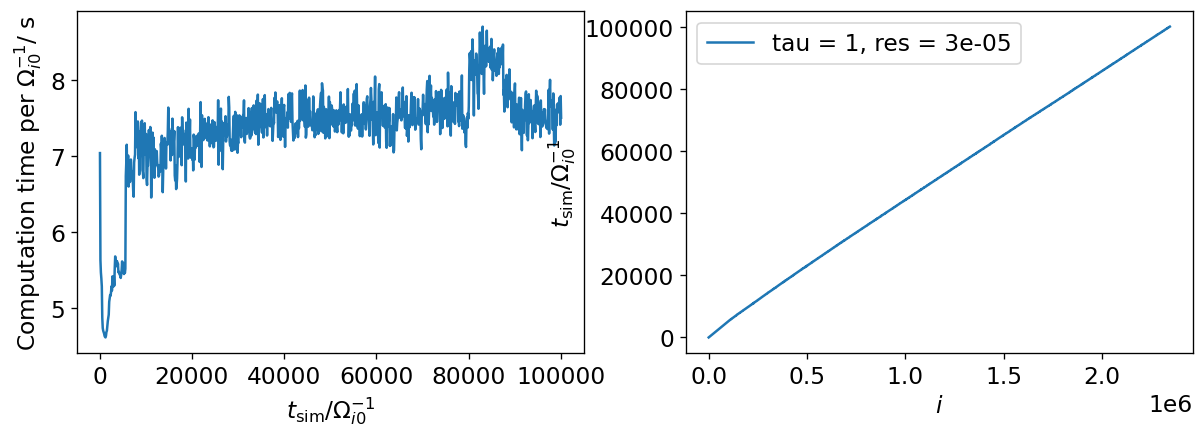

./resistivity-new-data/3ec81972a93bd5b7efb96fff8f32a128e879b6ea.out 1 0.0001
5.4±0.4
0.052


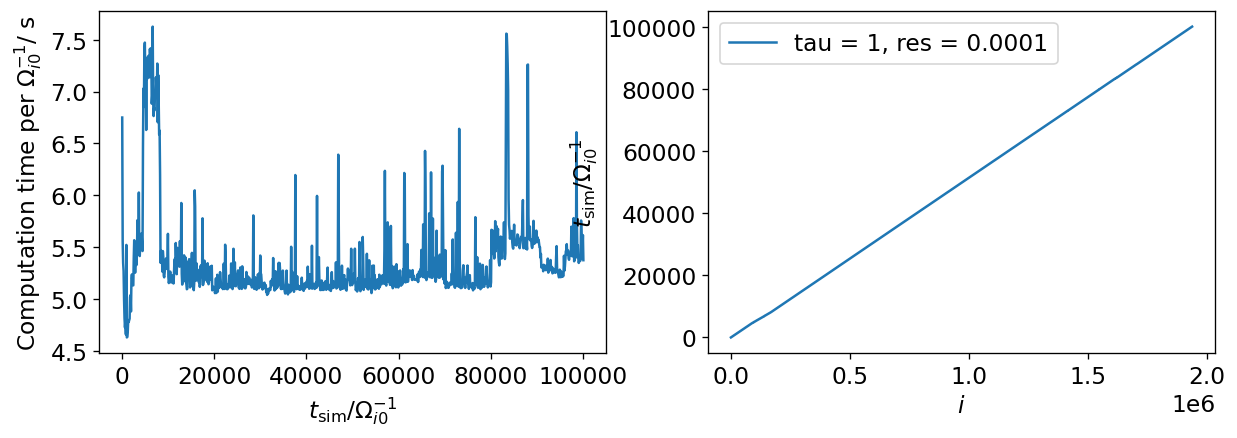

./resistivity-new-data/8ff727a75b374aeb38e1093af32542ef213cc1fe.out 1 0.0003
8.3±0.2
0.032


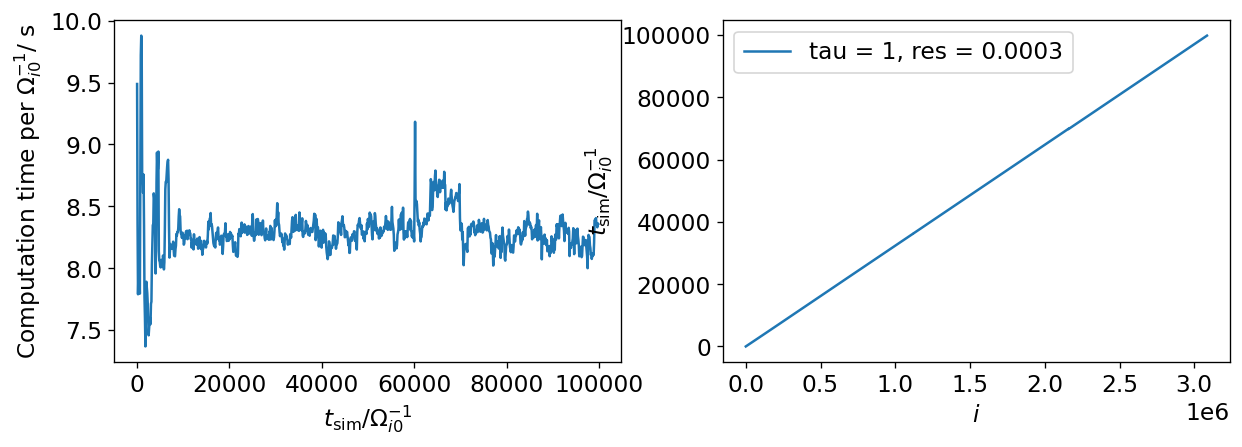

In [11]:
# Let's try to parse the out files from the simulations
import re 
filelist = outfiles.table()
filelist = sorted( filelist , key=lambda d: (d['physical']['tau'], d['physical']['resistivity']))
# for pp in filelist:
#     for i in range(0, outfiles.count(pp)):
#         print( outfiles.outfile( pp,i  ))
to_plott = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "avg_time": {0:dict(),1:dict()},
    "std_time": {0:dict(), 1:dict()},
    "avg_callstep" : {0:dict(), 1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
}
for pp in filelist:
    fig,axs=plt.subplots(1,2,figsize=(2*6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    tau = pp["physical"]["tau"]
    res = pp["physical"]["resistivity"]
   
    print( outfiles.outfile( pp ), tau , res)
    times = list()
    timings = list()
    calltimes = list()
    
    for i in range(0, outfiles.count( pp)):        
        
        with open (outfiles.outfile( pp,i  ) ) as file:
            for line in file:
                if "## time" in line:
                    calltimes.append( float(line.split()[2]))
                if "Step: Time " in line:
                    times.append( int(re.findall(r'\d+', line)[0]))
                if "Average time for one inner loop: " in line:
# https://stackoverflow.com/questions/4289331/how-to-extract-numbers-from-a-string-in-python
                    timings.append( float(re.findall(r'[\d]*[.][\d]+', line)[0]
                                         )/pp["timestepper"]["deltaT"]*pp["output"]["itstp"])
    calltimes = np.array( calltimes)
    print( f"{np.mean(timings):.1f}"+u"\u00B1"+f"{np.std(timings):.1f}")
    print( f"{times[-1]/len(calltimes):.3f}")
    to_plott["res"][tau].append(res)
    to_plott["avg_time"][tau][res] = np.mean(timings)
    to_plott["std_time"][tau][res] = np.std(timings)
    to_plott["avg_callstep"][tau][res] = times[-1]/len(calltimes)
    to_plott["params"][tau][res] = pp 
#     print( timings)
    ax = axs[0]
    ax.plot( times, timings, label = f"tau = {tau}, res = {res}")
    ax.set_xlabel(r"$t_\mathrm{sim}/ \Omega_{i0}^{-1}$" )
    ax.set_ylabel(r"Computation time per $\Omega_{i0}^{-1}$/ s" )
    ax = axs[1]
    ax.plot( calltimes, label = f"tau = {tau}, res = {res}")
    ax.set_xlabel(r"$i$" )
    ax.set_ylabel(r"$t_\mathrm{sim}/ \Omega_{i0}^{-1}$" )
    plt.legend()
    plt.show()

In [12]:

# Create simulation times table
datalist=list()
columns=[r"$\eta$",r"$t_\text{comp}(T_i=0) / s$", r"$t_\text{comp}(T_i=T_e) / s$"]

for res in to_plott['res'][0]:
    line = list()
    line.append(res)
    for tau in to_plott['tau'] :
        line.append( f"{to_plott['avg_time'][tau][res]:.1f} "  + u"\u00B1"+ 
                    f" {to_plott['std_time'][tau][res]:.1f}")
    datalist.append(line)
df = pd.DataFrame( datalist, columns=columns) 
df.sort_values( by = r'$\eta$', inplace=True)
df_str = df
for header in ["$\eta$"] :  
    df_str[header] = df_str[header].apply( errorToString)
df_str.set_index("$\eta$", inplace=True)

# df.columns=pd.MultiIndex.from_tuples(columns)

filename = "timings.tex"
with open(filename, 'wb') as f:
    f.write(bytes(df_str.style.to_latex(
        column_format='rcc', hrules=True),'UTF-8'))
    

df_str

,$t_\text{comp}(T_i=0) / s$,$t_\text{comp}(T_i=T_e) / s$
$\eta$,,
1.00e-06,5.3 ± 0.7,5.3 ± 0.2
3.00e-06,5.3 ± 0.8,5.3 ± 0.2
1.00e-05,5.6 ± 1.0,6.6 ± 0.3
3.00e-05,7.2 ± 0.2,7.4 ± 0.6
1.00e-04,4.6 ± 0.6,5.4 ± 0.4
3.00e-04,6.1 ± 0.4,8.3 ± 0.2


In [13]:
to_plott["calls_per_omega"] = {0:dict(),1:dict()}
calls= list()
for pp in filelist:
    tau = pp["physical"]["tau"]
    res = pp["physical"]["resistivity"]
    
    to_plott["calls_per_omega"][tau][res] = 1./to_plott["avg_callstep"][tau][res]
    calls.append(1./to_plott["avg_callstep"][tau][res])
print( np.mean(calls), np.std(calls))
to_plott["calls_per_omega"]

23.78477581514096 4.2867754428258955


{0: {1e-06: 21.613016304347827,
  3e-06: 21.703176043557168,
  1e-05: 22.435230769230767,
  3e-05: 33.74831,
  0.0001: 19.643806426288343,
  0.0003: 23.45226},
 1: {1e-06: 21.144830053667263,
  3e-06: 21.188660071942444,
  1e-05: 26.77756756756757,
  3e-05: 23.434919999999998,
  0.0001: 19.364259999999998,
  0.0003: 30.911272545090178}}

## 